# Final Project - Wine Classification Machine Learning Algorithm 
## Data Sciences MECE4520
### Leonardo Aquino Alves Belmar da Costa - la2700

This program intends to scrape websites that contain data on wines. By obtaining this datasets, it is possible to create a database of wine types, which will be used to create a machine learning method for determining what is the classification of a random sample. Not all tech sheets contain useful information, but most of them contain at least two parameters, which is why there will be some simplifications through this process. 

This notebook will create a data pipeline with database integration and machine learning capabilities to address the correlation between the main properties of wines and its respective types. One thing to keep in mind is that this program is an exploratory machine learning program, in which, there is no certantity that there will actually be enough difference between the types of wines that would help categorize them. 

Some important properties of wines are listed below:

- Total Acidity (TA): It tells us the concentration of acids present in wine.
- Residual Sweetness (RS): It is a measure of sweetness in wine thorugh sugar contnet.
- Alcohol Content (ABV, Alcohol % or Alc %): It is a measure of the alcohol percentage per volume. 
- pH (pH): It measures the intensity of acids in wine.
- Blend: percentage of each grape used. 

# Importing Packages

In [1]:
#Images package
from IPython.display import Image

#PDF to text reader
import PyPDF2
import io
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

#Scraping packages
from lxml import html 
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import Request, urlopen
import requests

#Database packages
from flask_sqlalchemy import SQLAlchemy
from sqlalchemy import *
import json

#Data Analysis packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#String manipulation packages
import re
import unidecode
import base64
import random
import string
import collections
from random import seed
from random import randint

# ML models
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn import utils

# Wine Tech Sheet
This is what a typical wine technical sheet looks like.
One observation we can draw from this image is that the techsheet does not directly mentions the wine type (red, white, rose). The main source of scraped data already separates the wines by type, but other techinical data sheets, do not necessarily have that differentiation. For that reason, other websites were scrapped to create an alternate database that correlates types of grape and types of wine.

<img src="tech_sheet.PNG">

In [2]:
### Opening the url, reading and decoding
url_main = 'http://minerwines.com/trade-and-media/data-sheets/'
req = Request(url_main, headers={'User-Agent': 'Mozilla/5.0'}) ### Because of Forbidden access, the User-Agent command
webpage = urlopen(req).read()                                  ### was used to read and decode the page

### parsing HTML text
soup = BeautifulSoup(webpage, 'html.parser')
page = requests.get(url_main)
tree = html.fromstring(page.content)

In [3]:
### Easily readable HTML
### This was just a vizualization so that generalizations could be made for the remaining links on the website
parsed_html = soup.prettify()
print(parsed_html)

<!DOCTYPE html>
<!--[if lt IE 7 ]> <html lang="en-US" prefix="og: http://ogp.me/ns#" class="no-js ie6"> <![endif]-->
<!--[if IE 7 ]>    <html lang="en-US" prefix="og: http://ogp.me/ns#" class="no-js ie7"> <![endif]-->
<!--[if IE 8 ]>    <html lang="en-US" prefix="og: http://ogp.me/ns#" class="no-js ie8"> <![endif]-->
<!--[if IE 9 ]>    <html lang="en-US" prefix="og: http://ogp.me/ns#" class="no-js ie9"> <![endif]-->
<!--[if (gt IE 9)|!(IE)]><!-->
<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">
 <!--<![endif]-->
 <head>
  <!-- Meta & Title 
-------------------------------------------------->
  <meta charset="utf-8"/>
  <!--Meta for Mobile Viewing -->
  <meta content="width=device-width,initial-scale=1.0,maximum-scale=1.0,user-scalable=0;" name="viewport"/>
  <link href="http://minerwines.com/wp-content/themes/minerwines2014/favicon.ico?x20247" rel="shortcut icon" type="image/x-icon"/>
  <title>
   Data Sheets - Miner Family Wines
  </title>
  <!-- Font Includes
--------

# Understanding HTML and finding patterns:
## Reading main vineyard pages, reading pdfs and extracting data

In [4]:
### Obtaining text of all possible wine classifications and the titles based on grape or type
### Tree.xpath is used to single out specific sections of the HTML file shown above
red_wine_class = tree.xpath('//div[@id = "ms-red"]//h2[@class="ms-wine"]//text()')
white_wine_class = tree.xpath('//div[@id = "ms-white"]//h2[@class="ms-wine"]//text()')
rose_wine_class = tree.xpath('//div[@id = "ms-rose"]//h2[@class="ms-wine"]//text()')
grape_class = tree.xpath('//h2[@class="ms-wine"]/text()')
print ("Red Wines:", red_wine_class)
print (" ")
print ("White Wines:", white_wine_class)
print (" ")
print ("Rose Wines:", rose_wine_class)

Red Wines: ['NHL® Wines', 'The Oracle', 'Cabernet Sauvignon', 'Cabernet Franc', 'Grenache', 'La Diligence Syrah', 'Malbec', 'Merlot', 'Pinot Noir', 'Petite Sirah', 'Sangiovese', 'Syrah', 'Tempranillo', 'The Odyssey', 'Retired']
 
White Wines: ['Chardonnay', 'La Diligence Marsanne', 'Sauvignon Blanc', 'The Iliad', 'Viognier', 'Roussanne']
 
Rose Wines: ['Rosato']


In [5]:
### Obtaining hyperlinks 
wine_list = []
url_list = []
for link in soup.findAll('a', attrs={'href': re.compile("^http://")}):  ### Finding all instances of http
    if "uploads/" in link.get('href'):                                  ### Finding all instances of http that also
        wine_list.append(link.get('href'))                              ### contain upload
        
for link in soup.findAll('a', attrs={'href': re.compile("^http://")}):
    url_list.append(link.get('href'))

print (" ")
print ("The number of links obtained is: ",len(url_list))      ### List of alll hyperlinks
print (" ")
print ("The number of technical sheet links obtained is: ",len(wine_list))### List of hyperlinks that leads to wine data

 
The number of links obtained is:  445
 
The number of technical sheet links obtained is:  394


By using soup.findAll it is possible to obtain hyperlinks withing the first webpage. Each hyperlink represents technical sheet webpages. However, there are other hyperlinks that redirect to pages that are not interesting for this project. Because of that, two for loops were created to identify all possible hyperlinks and the ones that will provide useful data.

The first for loop obtains all of the available links.

The second for loop obtains all links that refer to tech sheet files (Specific tech sheets of each wine).

In [6]:
### Test Technical Datasheet for wine_list
print (wine_list[0])

http://minerwines.com/wp-content/uploads/2018/12/16nhlallstar.pdf?x20247


In [7]:
### This function is used to download each PDF file available from the list of hyperlinks bellow
def download_file(download_url):
    req = Request(download_url, headers={'User-Agent': 'Mozilla/5.0'}) # Similar to scraping the website, an agent is 
    response = urlopen(req)                                            # used to successfully open all of the links
    file = open("document.pdf", 'wb')                                  # Opening file for binary writting 
    file.write(response.read())
    file.close()

In [8]:
### Function that opens, reads and returns the PDF scraped text for the most recent document downloaded
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')                                                     # Creating a pdf File object
    interpreter = PDFPageInterpreter(rsrcmgr, device)                         # Creating a pdf Reader object
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()
    
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)                                       # Creating a page object

    text = retstr.getvalue()                                                 # Extracting text from page

    fp.close()                                                               
    device.close()
    retstr.close()
    return text                                                              # Returns readable text

In [9]:
### Testing aboove functions on a random file
download_file(wine_list[9])
pdf_text = convert_pdf_to_txt("document.pdf")
print (pdf_text)

2014 

The Oracle

N a p a   V a l l e y   R e d   W i n e

Our flagship wine, a full-bodied, single vineyard red blend, grants a nod 
toward elegance for the 2014 vintage. This Bordeaux-style blend is silky, 
reserved and supremely balanced.  
 
Lush aromatics of raspberry and dark cherry with a hint of eucalyptus, 
The Oracle is decadent, but with finesse. Earthiness and layers of dried 
flowers and cocoa integrate harmoniously into a finely balanced mar-
riage between tannin and acid, providing the structure that ensures, like 
all impeccable beauties, this wine is sure to age gracefully.  
 
 

ANALYSIS 
Alcohol 14.6% 
pH 3.53 
TA .63 
PRODUCTION 
4,584 6-packs 
BOTTLED 
August 2016 
RELEASE DATE 
Summer 2018 
SUGGESTED RETAIL 
$100

APPELLATION  
100% Napa Valley
VINEYARD 
100% Stagecoach Vineyard 
BLEND  
55% Cabernet Sauvignon
19% Cabernet Franc 
19% Merlot
3% Petit Verdot
3% Malbec
HARVEST 
September 24th - October 13th, 2014 
Picked at 24.6 - 27.9 Brix 
FERMENTATION 
22 Months

# Finding patterns in tech sheets

One aspect of the tech sheets in this websites is the overall baseline of each document. The useful data can be found in the Analysis block. The data consists of alcohol content, pH and TA. A function will be used to extract data of all possible wine links.

In [10]:
### Obtaining Data

#Index - shows the index of the first letter of the feature we are looking for in-text 
#Len - is the length of the word (how many letter does it contain) plus 1 character
#Data Len - is the number of characters of the numerical data associated with that feature

### Obtaining Alcohol Data
Alc_index = pdf_text.find("Alcohol")
Alc_len = 8    ### 7 characters to write the word alcohol and one extra character for the space following the word
Alc_data_len = 4   ### 4 characters to obtain float number (double digit) with 1 decimal point
Alc_data = pdf_text[Alc_index + Alc_len :Alc_index + Alc_len + Alc_data_len]
print (Alc_data)

# Obtaining pH Data
ph_index = pdf_text.find("pH")
ph_len = 3    ### 2 characters to write the word ph and one extra character for the space following the word
ph_data_len = 4  ### 4 characters to obtain float number (single digit) with 2 deciaml points
ph_data = pdf_text[ph_index + ph_len :ph_index + ph_len + ph_data_len] 
print (ph_data)

# Obtaining TA Data
ta_index = pdf_text.find("TA")
ta_len = 2  ### 2 characters to write the word TA
ta_data_len = 4 ### 4 characters to write the space plus the 3 characters for the float number with two decimal points
ta_data = pdf_text[ta_index + ta_len :ta_index + ta_len + ta_data_len] 
print (ta_data)

14.6
3.53
 .63


In [11]:
### Function that reads in data for each feature and takes in the current pdf file, feature name, 
### len and data len as its parameters
def read_data(filename, feature, feature_len, feature_data_len):
    if feature not in filename:
        return np.nan
    feature_index = filename.index(feature)
    feature_data = filename[feature_index + feature_len :feature_index + feature_len + feature_data_len]
    return feature_data 

In [12]:
### Testing data collection function
read_data(pdf_text,"Alcohol",8,4)

'14.6'

In [13]:
# Trying to read files
### This block of code takes a couple of minutes to run because it downloads, reads and extracts data from all PDFs
### The last PDF will still be saved in the current repository as document.pdf
### Cache tools were attempted to save time running the program the second time, but because of other exceptions, they
### were ommited from this code
del_list = []
Alc_dataset = []
pH_dataset = []
TA_dataset = []
price_dataset = []
for link in wine_list:
    download_file(link)  
    try:
        pdf_text = convert_pdf_to_txt("document.pdf")
        TA_dataset.append(read_data(pdf_text,"TA",2,4))
        Alc_dataset.append(read_data(pdf_text,"Alcohol",8,4))
        pH_dataset.append(read_data(pdf_text,"pH",3,4))
    except TypeError:
        del_list.append(link)
        continue
    except:
        del_list.append(link)
        continue

Using the same algorithm as last cell, we can iterate through all the loops and obtain the desired data for all
files. The only problems that still need to be taken care of are the exceptions of files that either do not open
or simply dont have data attached, which means we will add NaN for those datapoints.

In [14]:
# Investigating results from read_file() 
### Some files probalby raised exceptions, which is why they will be removed from the main list of hyperlinks
print ("Size of arrays prior to manipulation:")
print (len(wine_list))
print (len(del_list))

Size of arrays prior to manipulation:
394
8


In [15]:
# Cleaning up the data 
for item in del_list:
    if item not in wine_list: ### Removing faulty files from the main list of hyperlinks 
        continue
    else:
        wine_list.remove(item)
    
print ("Size of arrays post manipulation:")
print (len(wine_list))
print (len(del_list))

Size of arrays post manipulation:
386
8


As seen here, out of the 394 links available, 8 of them seem to defective in some way and 386 seem to work
However, not all 386 provided good information. The next step will be to create the dataframe that will help
give an insight in how the results will be handled. 

In [16]:
### Differentiating between categories of wines. 
### Because it is easy to determine when the white wines and rose wines begin, I can find their indexes so that
### a column can be added with each wines classification. That is possible because the source of all the PDF files 
### already separates the wines by red, white and rose

white_index = wine_list.index("http://minerwines.com/wp-content/uploads/2018/04/15Gennys.pdf?x20247")
rose_index = wine_list.index("http://minerwines.com/wp-content/uploads/2019/03/18Rosato.pdf?x20247")
i = 0
wine_category = []
while i < white_index:             # Every wine before this index references a red wine
    wine_category.append("Red")
    i += 1
while i < rose_index:              # Every wine between this index and the rose_index references a white wine
    wine_category.append("White")
    i += 1
while i < len(wine_list):          # Every wine after this index references a rose wine
    wine_category.append("Rose")    
    i += 1
    

In [17]:
### Creating an ID for each wine
wine_id_list = []
for i in range (len(wine_category)):   ### Generating ID's for each datapoint  
    random_id_wine = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(15)])
    while random_id_wine in wine_id_list:     ### Avoiding the possibility of having different wines with the same ID
        new_random_id_wine = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(15)])
        wine_id_list.append(new_random_id_wine)
    wine_id_list.append(random_id_wine)

In [18]:
#print (Alc_dataset, pH_dataset, TA_dataset)
df = pd.DataFrame({"Wine_ID":wine_id_list,"Category":wine_category, "Alcohol":Alc_dataset, 
                   "pH":pH_dataset, "TA":TA_dataset})
df

,Wine_ID,Category,Alcohol,pH,TA
0,3h8wBXJBEvJ3UZo,Red,14.5,3.62,.65
1,HyUiCIFQf6XPJef,Red,14.9,3.61,.62
2,RSC4TkVSl1odprU,Red,14.9,3.61,.62
3,nY0B1bXqkmrGqMs,Red,14.9,3.61,.62
4,bBodBHgRvtcknGn,Red,14.9,3.61,.62
5,KlkIvOA9L3jAydF,Red,14.9,3.61,.62
6,1jXtB6Tb0kEX9A8,Red,14.9,3.61,.62
7,YoumLVXiGMF2Z0L,Red,14.9,3.61,.62
8,Fu4UIrloLBgzK0X,Red,14.9,3.61,.62
9,yej60czzDtHZTNN,Red,14.6,3.53,.63


# Data Analysis and Exploration
For the data analysis, first we need to address the values that were blank or that the scraping was not able to decipher. For that, we will obtain a number of datapoints that contain blank values and determine if they are worth keeping.

In [19]:
### Assigning floats to numerical values 
for alc in df["Alcohol"]:
    try:
        alc_float = float(alc)
        df = df.replace(alc,alc_float)
    except:
        df = df.replace(alc, np.nan)
for ph in df["pH"]:
    try:
        ph_float = float(ph)
        df = df.replace(ph,ph_float)
    except:
        df = df.replace(alc, np.nan)
for ta in df["TA"]:
    try:
        ta_float = float(ta)
        df = df.replace(ta,ta_float)
    except:
        df = df.replace(ta, np.nan)

In [20]:
### Handling missing data (NaN values)
alc_miss = list(np.where(np.isnan(df["Alcohol"]))[0])
ph_miss = list(np.where(np.isnan(df["pH"]))[0])
ta_miss = list(np.where(np.isnan(df["TA"]))[0])
missing_data = alc_miss + ph_miss + ta_miss
percent_loss = 100*(len(missing_data)/len(wine_list))  ### Determining how much data represents NaN values
print ("The percent loss of data by deleting NaN values is equal to:", percent_loss, "%")

The percent loss of data by deleting NaN values is equal to: 33.93782383419689 %


In [21]:
### Printing difference between clean and raw dataframes 
df_clean = df.dropna()                      # Clean data means deleting rows that have at least 1 value equal to NaN
df_clean_filled = df.fillna(method="ffill") # Filled data adds values similar to the existing values for NaN cells
print ("Raw data has: " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " rows")
print ("Modified data has: " + str(df_clean.shape[1]) + " columns and " + str(df_clean.shape[0]) + " rows")
print ("Modified filled data has: " + str(df_clean_filled.shape[1]) + " columns and " + 
       str(df_clean_filled.shape[0]) + " rows")

Raw data has: 5 columns and 386 rows
Modified data has: 5 columns and 263 rows
Modified filled data has: 5 columns and 386 rows


In the above cell, I modified the data in order to handle missing values. Upon reviewing the amount of rows that would have to be dropped to clean out the raw dataset, it was determined that around 30% of data would be lost in the process, reducing the amount of data points from 386 to 263. Another method was to fill the data using a dataframe function. In order to determine how accurate that method is, the analysis will be conducted on both datasets - dropped and filled. 

## Exploring Modified data - Dropped NaN

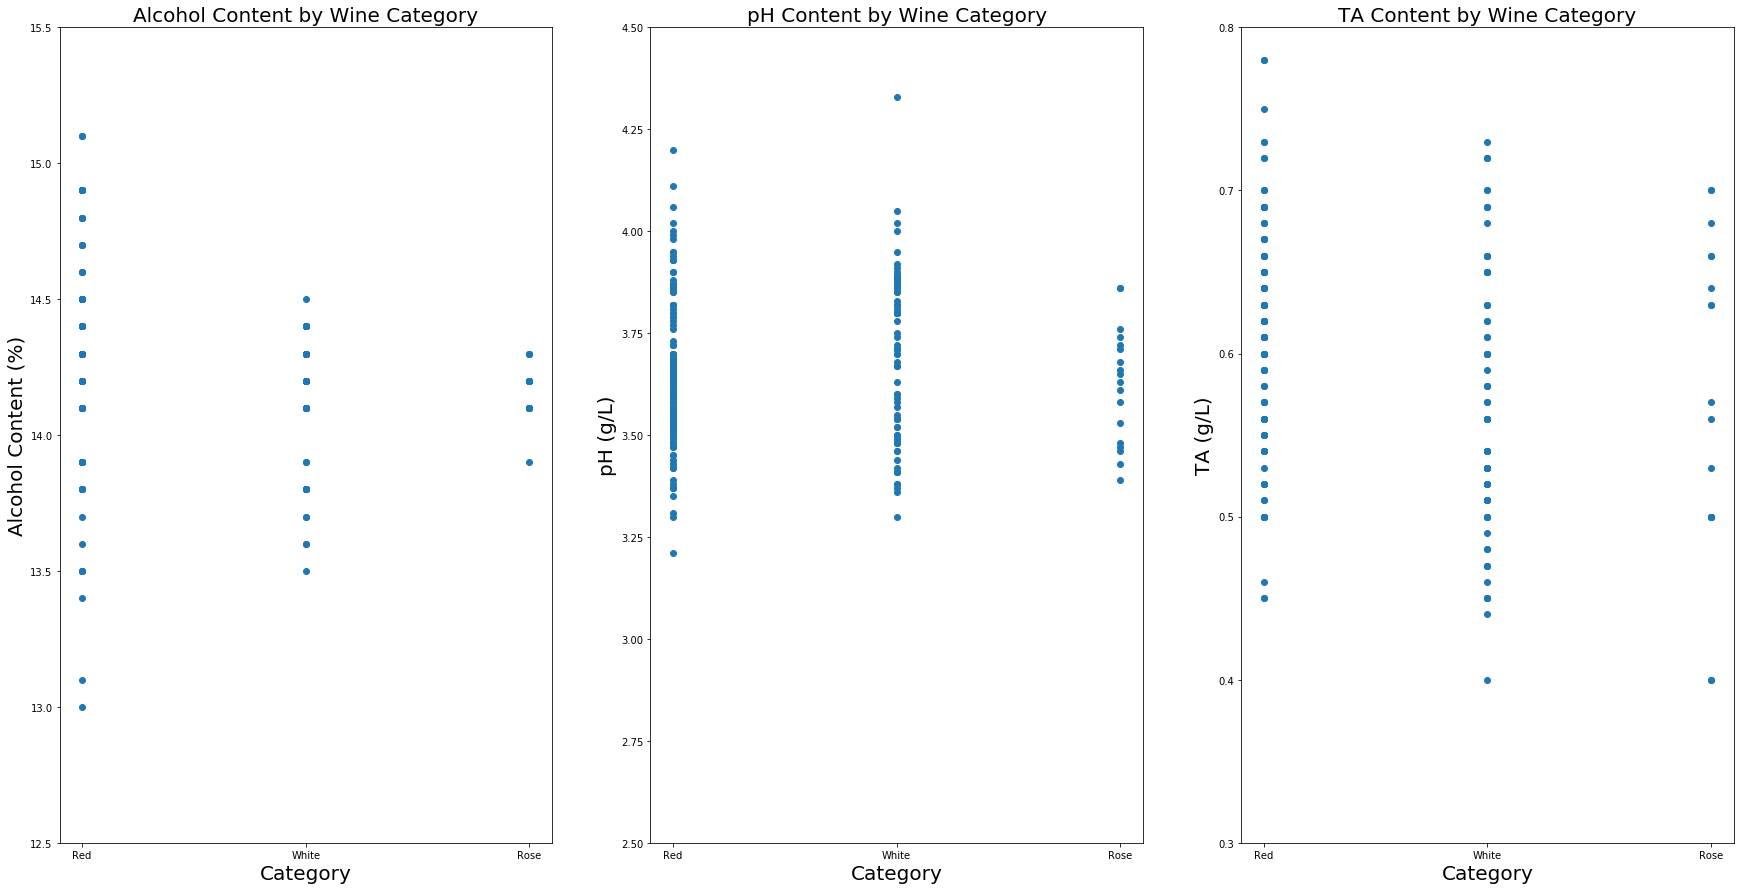

In [22]:
### Exploring data values and observing trends 
fig = plt.figure(figsize=(30, 15),facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(1,3,1) ### Alcohol Feature set by wine category
ax1.scatter(df_clean["Category"], df_clean["Alcohol"]) 
ax1.set_ylim([12.5, 15.5])
ax1.set_ylabel("Alcohol Content (%)",fontsize=20)
ax1.set_xlabel("Category",fontsize=20)
ax1.set_title("Alcohol Content by Wine Category",fontsize=20)

ax2 = fig.add_subplot(1,3,2) ### pH Feature set by wine category
ax2.scatter(df_clean["Category"], df_clean["pH"])
ax2.set_ylim([2.5, 4.5])
ax2.set_ylabel("pH (g/L)",fontsize=20)
ax2.set_xlabel("Category",fontsize=20)
ax2.set_title("pH Content by Wine Category",fontsize=20)

ax3 = fig.add_subplot(1,3,3) ### TA Feature set by wine category
ax3.scatter(df_clean["Category"], df_clean["TA"])
ax3.set_ylim([0.3, 0.8])
ax3.set_ylabel("TA (g/L)",fontsize=20)
ax3.set_xlabel("Category",fontsize=20)
ax3.set_title("TA Content by Wine Category",fontsize=20)

plt.show()

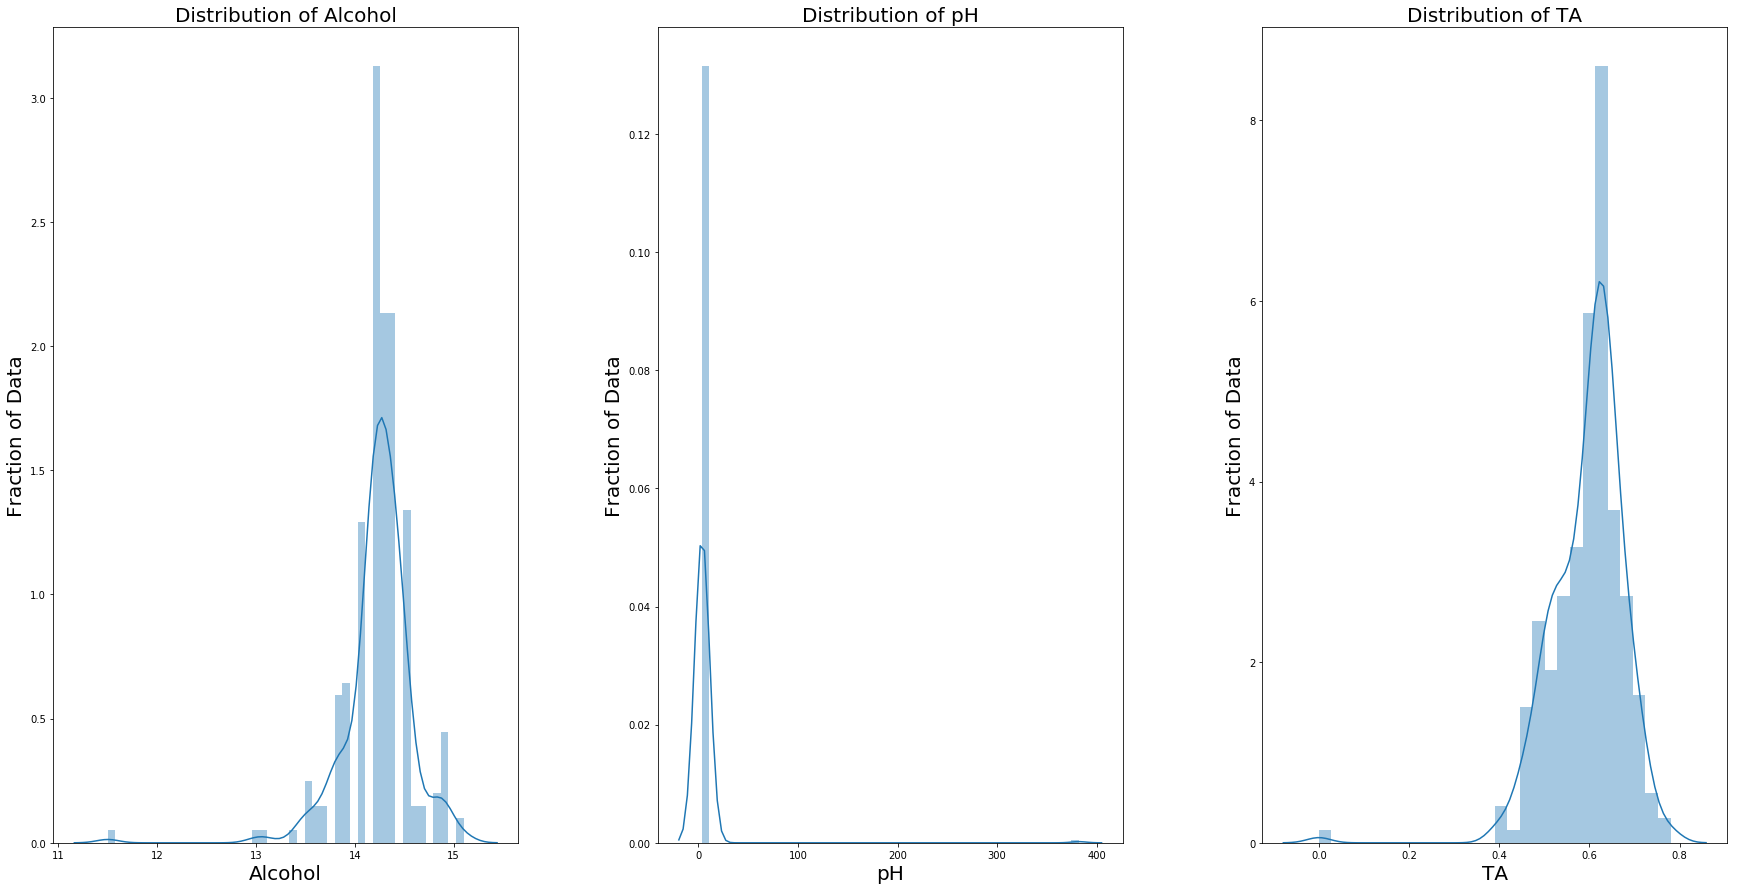

In [23]:
### Distribution plots for further investigation of data
fig = plt.figure(figsize=(30, 15),facecolor='w', edgecolor='k')
X = df_clean["Category"]
Y = df_clean[["Alcohol","pH","TA"]]
for num,feature in enumerate(list(Y),1): ### For loop that plots all Distribution graphs
    ax = fig.add_subplot(1,3,num)
    sns.distplot(df_clean[feature])
    ax.set_title('Distribution of '+ feature, fontsize=20)
    ax.set_xlabel(feature, fontsize=20)
    ax.set_ylabel('Fraction of Data', fontsize=20)
    plt.subplots_adjust(hspace = .9,wspace=.3)

From the observations of the data above, we can conclude that the red wine data points span a larger image for two of the three features. In addition, the pH data for red wine shows a more spread out array of values. Meanwhile, the alcohol data for all categories seems to follow a pattern judging from the data points plotted. That can also be a reflection of different families of wine.

The distribution plots show how the data follows a approximate normal distribution for the the alcohol feature, a normal distribution for the pH feature - except for the outlier value - and mostly a random distribution for the TA feature. For the scatter plots, I purposely limited the y axis in order to get a clear vision of the plots. But as we can see in the distribution plots, all graphs present outliers, which could affect the results of an ML model.

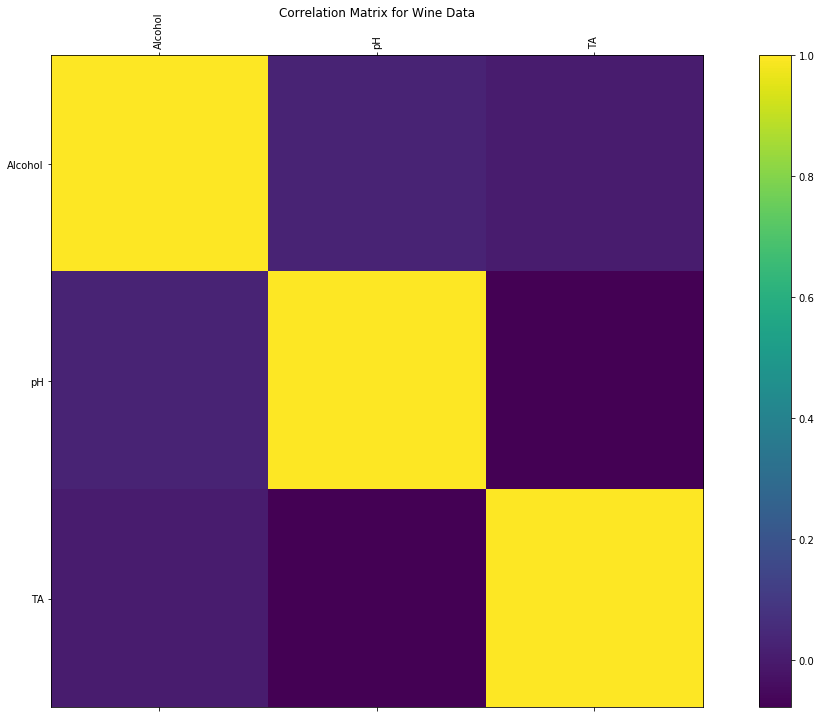

In [24]:
fig, ax = plt.subplots(figsize=(20,12))
plot = ax.matshow(Y.corr())
plt.xticks(np.arange(0, len(list(Y)), step=1))
plt.yticks(np.arange(0, len(list(Y)), step=1))
fig.colorbar(plot)
ax.set_title("Correlation Matrix for Wine Data", )
ax.set_xticklabels(list(Y), rotation='vertical')
ax.set_yticklabels(list(Y))
plt.show()

## Exploring Modified data - Filled NaN

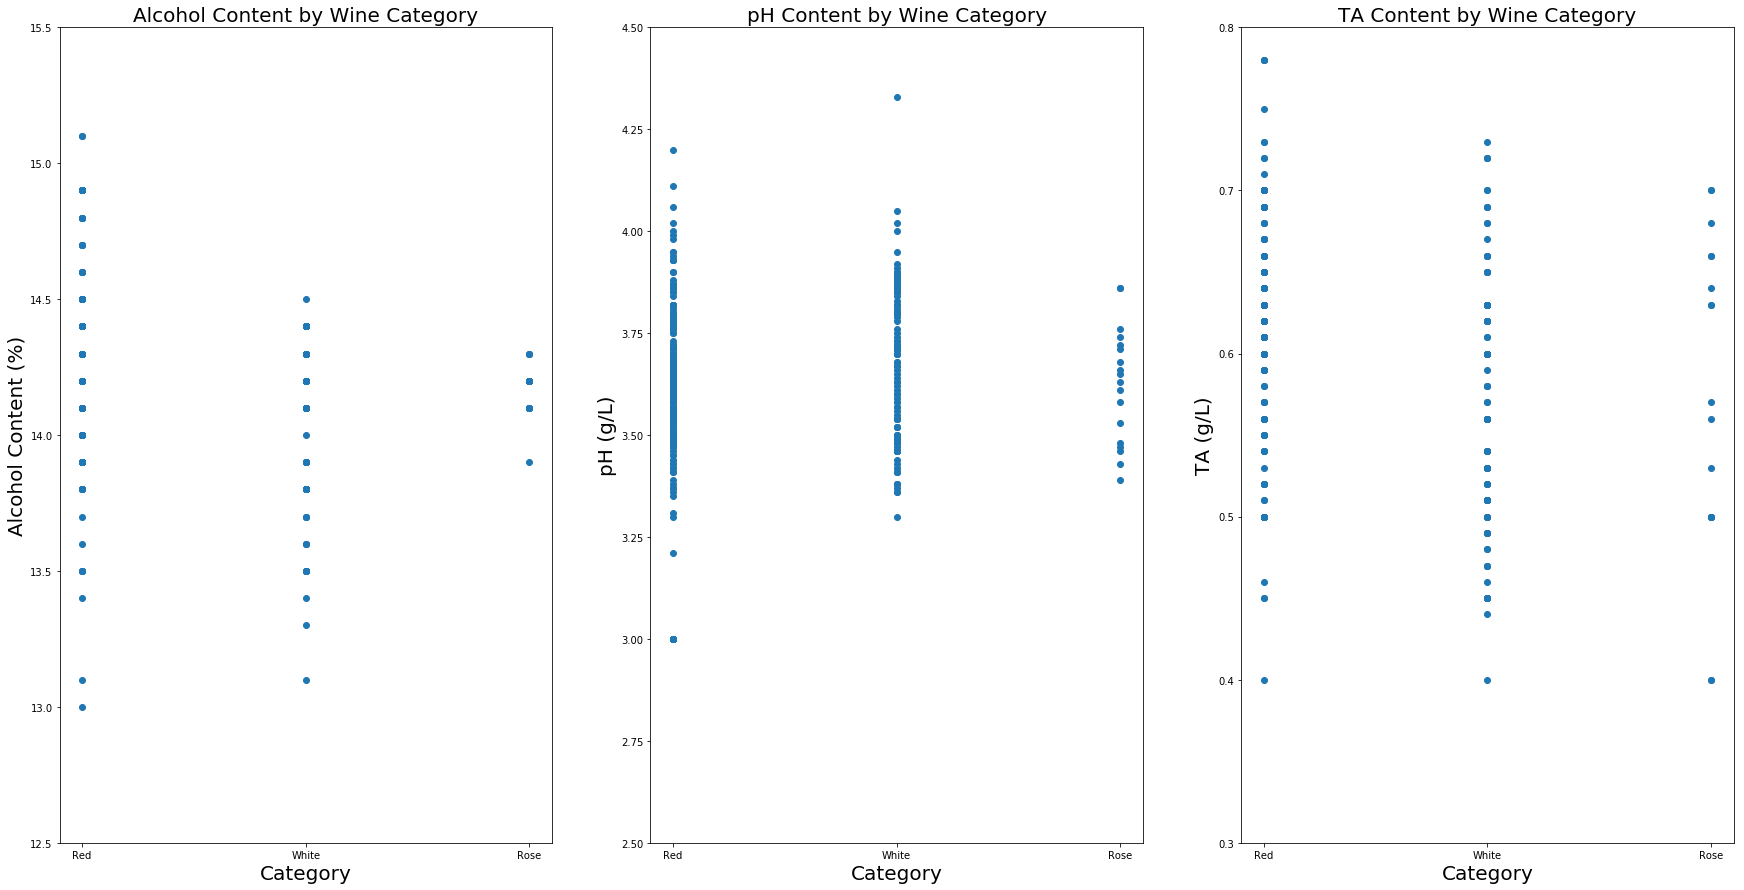

In [25]:
### Exploring data values and observing trends 
### The same process as seen above will be repeated for filled data
fig = plt.figure(figsize=(30, 15),facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df_clean_filled["Category"], df_clean_filled["Alcohol"])
ax1.set_ylim([12.5, 15.5])
ax1.set_ylabel("Alcohol Content (%)", fontsize=20)
ax1.set_xlabel("Category", fontsize=20)
ax1.set_title("Alcohol Content by Wine Category", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df_clean_filled["Category"], df_clean_filled["pH"])
ax2.set_ylim([2.5, 4.5])
ax2.set_ylabel("pH (g/L)", fontsize=20)
ax2.set_xlabel("Category", fontsize=20)
ax2.set_title("pH Content by Wine Category", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df_clean_filled["Category"], df_clean_filled["TA"])
ax3.set_ylim([0.3, 0.8])
ax3.set_ylabel("TA (g/L)", fontsize=20)
ax3.set_xlabel("Category", fontsize=20)
ax3.set_title("TA Content by Wine Category", fontsize=20)

plt.show()

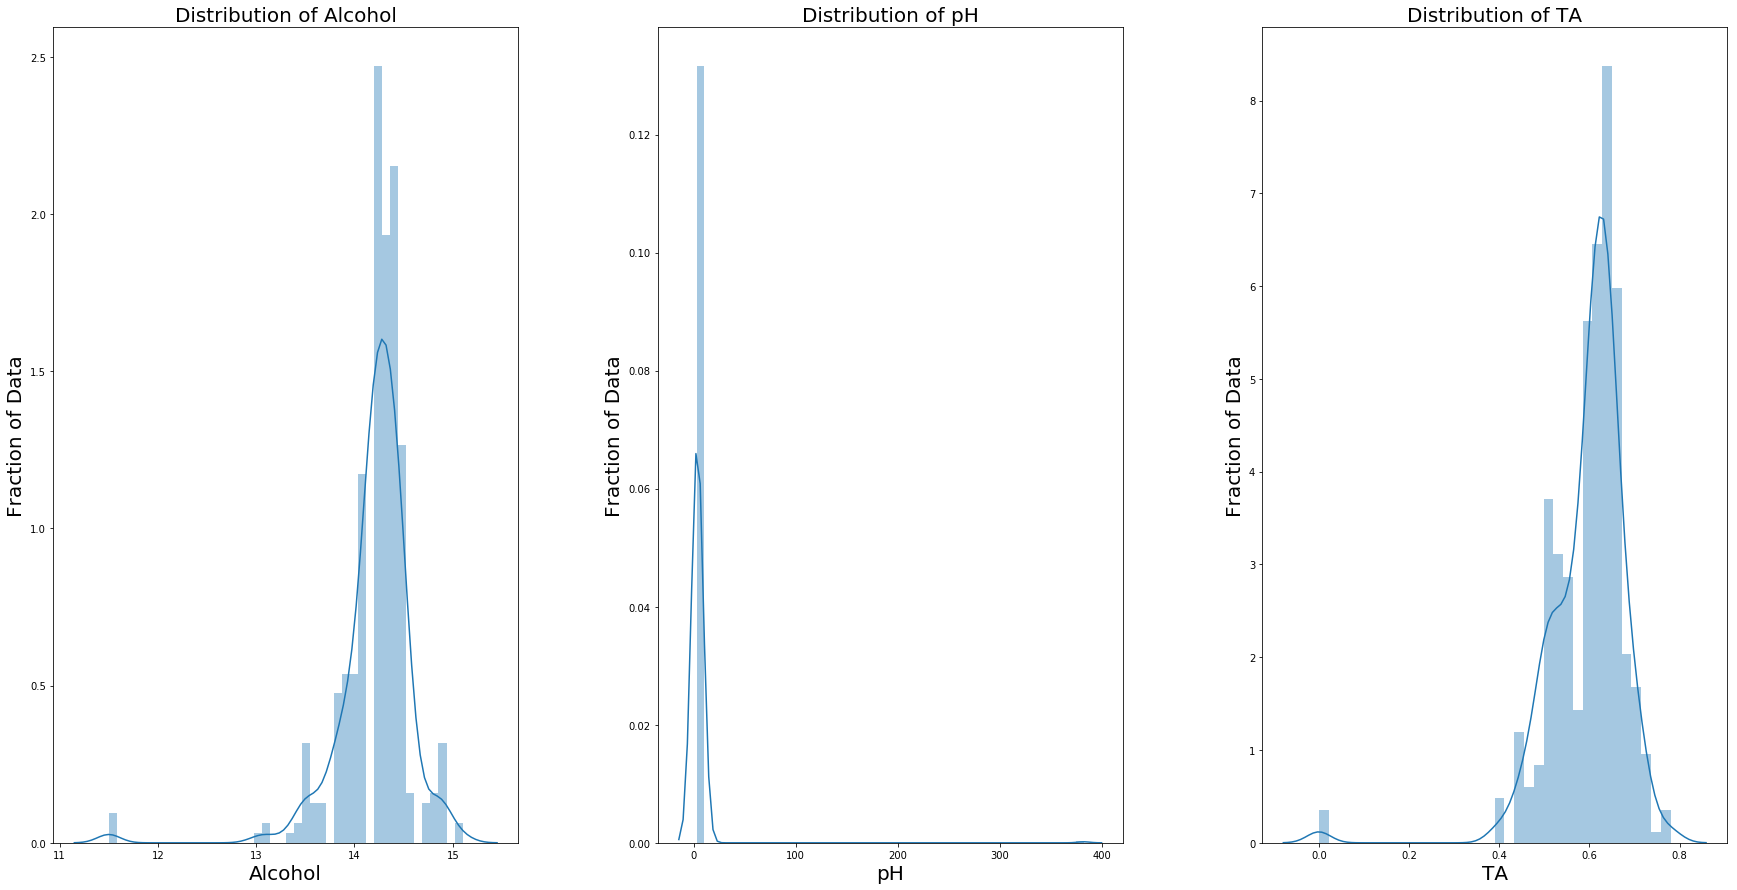

In [26]:
### Distribution plots for further investigation of data
fig = plt.figure(figsize=(30, 15),facecolor='w', edgecolor='k')
X = df_clean_filled["Category"]
Y = df_clean_filled[["Alcohol","pH","TA"]]
for num, feature in enumerate(list(Y),1):
    ax = fig.add_subplot(1,3,num)
    sns.distplot(df_clean_filled[feature])
    ax.set_title('Distribution of '+ feature, fontsize=20)
    ax.set_xlabel(feature, fontsize=20)
    ax.set_ylabel('Fraction of Data',fontsize=20)
    plt.subplots_adjust(hspace = .9,wspace=.3)

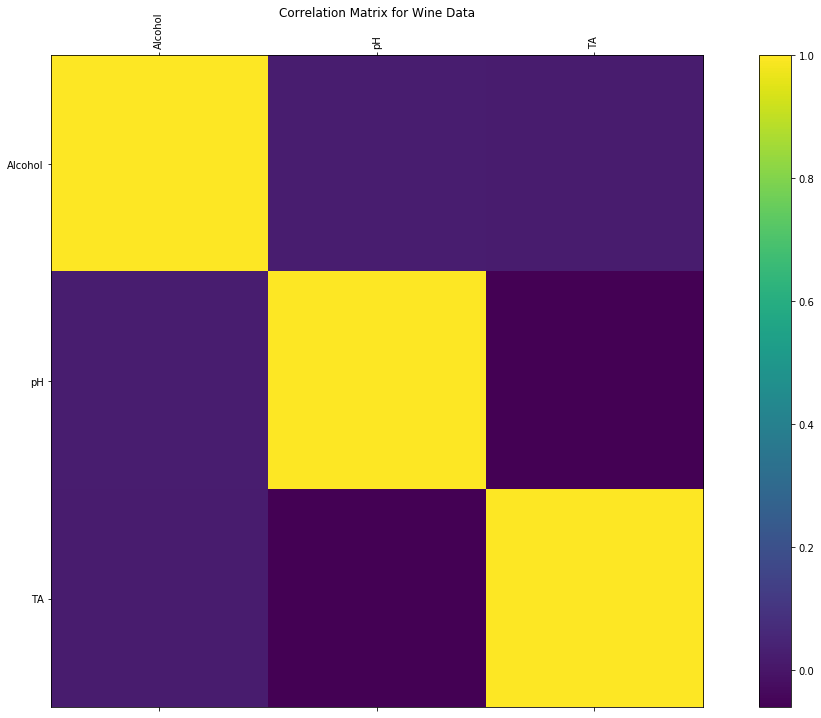

In [27]:
fig, ax = plt.subplots(figsize=(20,12))
plot = ax.matshow(Y.corr())
plt.xticks(np.arange(0, len(list(Y)), step=1))
plt.yticks(np.arange(0, len(list(Y)), step=1))
fig.colorbar(plot)
ax.set_title("Correlation Matrix for Wine Data", )
ax.set_xticklabels(list(Y), rotation='vertical')
ax.set_yticklabels(list(Y))
plt.show()

From comparing both data cleaning options, it can be seen that the differences between dropped NaN data points and filled NaN data points is irrelevant. The scatter plots and the distribution plots look similar. The only visual change that is perceptible is shown in the correlation matrices. Nevertheless, the color change is very small on the bottom left and top right box - correlation between alcohol and TA. Given that information, in order to proceed with the ML models, the filled dataframe will be used due to the extra number of data points.

## Data Analysis - Machine Learning Model

In [28]:
## Separating wine categories - getting train data for both categories of wines

### Red
df_red = df_clean_filled.loc[df_clean_filled["Category"] == "Red"]
X_red = df_red[["Alcohol","pH","TA"]]
red_target = []
for i in range(len(X_red)):
    red_target.append(0)
Y_red = pd.DataFrame({"Classification":red_target})
X_train_red,X_test_red,y_train_red,y_test_red=train_test_split(X_red,Y_red,random_state=42) # Splits data

### White
df_white = df_clean_filled.loc[df_clean_filled["Category"] == "White"]
X_white = df_white[["Alcohol","pH","TA"]]
white_target = []
for i in range(len(X_white)):
    white_target.append(1)
Y_white = pd.DataFrame({"Classification":white_target})
X_train_white,X_test_white,y_train_white,y_test_white=train_test_split(X_white,Y_white,random_state=42) # Splits data

### Cobining train and test sets 
X_train = pd.concat([X_train_red, X_train_white]) 
X_test = pd.concat([X_test_red, X_test_white])
y_train = pd.concat([y_train_red, y_train_white])
y_test = pd.concat([y_test_red, y_test_white])

The red and white wine list were separated so that a substancial amount of each would be used for the train and test data. That is why the first portion of the code above slices the main dataframe for all values that have a red classification and white classification separately. In the second portion of the code concatenates both training and test sets.

# Determining what model to use:
In order to determine what classification model to be used, the sickit-learn ML tree will be used as a reference. Following the rationale, a classification model should be used to identify the between the types of wines. Because the data gathered has less than 100 thousand data points,  the first model available is a Linear SVC model, but in order to compare results a KNN model will also considered.
<img src="ML_decision.png">

# First Model: Linear SVC

In [29]:
num_iter = 10000
score_svc_list = []
while num_iter < 10000*10:      ### Loop that tries to iterate on Linear SVC to determine different accuracy results
    clf = LinearSVC(random_state=0, tol=1e-5, max_iter=num_iter)  ### Setting Classificator
    clf.fit(X_train, np.ravel(y_train))                           ### Fitting train data
    pred_svc = clf.predict(X_test)                                ### Predicting test data
    real_values = y_test["Classification"].tolist()        
    print("The associated coefficients for this Linear Supported Vector Classification are:",clf.coef_)
    print("The intercept for this Linear Supported Vector Classification is:", clf.intercept_)
    correct_list_svc = []
    max_score_svc = 0
    for i in range(len(pred_svc)):
        if pred_svc[i] == real_values[i]:
            correct_list_svc.append("Correct")
    score_svc = (len(correct_list_svc)/len(real_values)*100)
    score_svc_list.append(score_svc)
    print ("The correct percentage of predictions was:", score_svc)    ### Outputing max score 
    num_iter += 10000

The associated coefficients for this Linear Supported Vector Classification are: [[-0.31597985  0.81350704 -1.43529351]]
The intercept for this Linear Supported Vector Classification is: [2.02160118]
The correct percentage of predictions was: 72.82608695652173
The associated coefficients for this Linear Supported Vector Classification are: [[-0.31597985  0.81350704 -1.43529351]]
The intercept for this Linear Supported Vector Classification is: [2.02160118]
The correct percentage of predictions was: 72.82608695652173
The associated coefficients for this Linear Supported Vector Classification are: [[-0.31597985  0.81350704 -1.43529351]]
The intercept for this Linear Supported Vector Classification is: [2.02160118]
The correct percentage of predictions was: 72.82608695652173
The associated coefficients for this Linear Supported Vector Classification are: [[-0.31597985  0.81350704 -1.43529351]]
The intercept for this Linear Supported Vector Classification is: [2.02160118]
The correct perce

# Second Model: KNN

In [30]:
max_score_knn = 0
score_knn_list = []
for num in range(1,10):          ### Loop that iterates through different number of neighbors 
    n_neighbors = num
    knn = KNeighborsClassifier(n_neighbors)      ### Setting Classificator
    knn.fit(X_train, np.ravel(y_train))          ### Fitting train data
    pred_knn = knn.predict(X_test)               ### Predicting test data
    real_values = y_test["Classification"].tolist()
    correct_list_knn = []
    for i in range(len(pred_knn)):
        if pred_knn[i] == real_values[i]:
            correct_list_knn.append("Correct")
    score_knn = (len(correct_list_knn)/len(real_values)*100)
    score_knn_list.append(score_knn)
    print ("The correct percentage of predictions was:", score_knn, "% for", n_neighbors, "neighbours")  ### Outputing
    if score_knn > max_score_knn:                                                                        ### max score
        max_score_knn, max_num = score_knn, num
print (" ")
print ("The best arrangment seems to be when the number of neighbours equals ", 
       max_num, "with an accuracy of", max_score_knn)

The correct percentage of predictions was: 73.91304347826086 % for 1 neighbours
The correct percentage of predictions was: 76.08695652173914 % for 2 neighbours
The correct percentage of predictions was: 78.26086956521739 % for 3 neighbours
The correct percentage of predictions was: 76.08695652173914 % for 4 neighbours
The correct percentage of predictions was: 82.6086956521739 % for 5 neighbours
The correct percentage of predictions was: 80.43478260869566 % for 6 neighbours
The correct percentage of predictions was: 81.52173913043478 % for 7 neighbours
The correct percentage of predictions was: 77.17391304347827 % for 8 neighbours
The correct percentage of predictions was: 81.52173913043478 % for 9 neighbours
 
The best arrangment seems to be when the number of neighbours equals  5 with an accuracy of 82.6086956521739


In order to determine if the Machine Learning Model is good enough, we need to compare the accuracy of the results of this classification with random guessing values. Since there are only two possibilities, by randomly assigning 0 or 1, we can determine if the best KNN model is better. 

# Third Model: Random Guessing 

In [31]:
max_score_rand = 0
score_rand_list = []
for num in range(1,10):      ### Loop that iterates to obtain 9 tries
    value_list = []
    for i in range(92):
        value_list.append(randint(0, 1)) ### Random integers assigned (size of sample is equal to size of test data)
    real_values = y_test["Classification"].tolist()
    correct_list_rand = []
    for i in range(92):
        if value_list[i] == real_values[i]:
            correct_list_rand.append("Correct")
    score_rand = (len(correct_list_rand)/len(real_values)*100)
    score_rand_list.append(score_rand)
    print ("The correct percentage of predictions was:", score_rand)
    if score_rand > max_score_rand:
        max_score_rand = score_rand
print (" ")
print ("The best arrangment seems to be when with an accuracy of", max_score_rand)    ### Outputting max score

The correct percentage of predictions was: 52.17391304347826
The correct percentage of predictions was: 61.95652173913043
The correct percentage of predictions was: 51.08695652173913
The correct percentage of predictions was: 50.0
The correct percentage of predictions was: 43.47826086956522
The correct percentage of predictions was: 43.47826086956522
The correct percentage of predictions was: 47.82608695652174
The correct percentage of predictions was: 50.0
The correct percentage of predictions was: 53.2608695652174
 
The best arrangment seems to be when with an accuracy of 61.95652173913043


## Conclusion Analysis
From what we can perceive, it is unlikely to obtaining higher accuracy by random guessing in comparison to using the KNN Machine Learning model and the Linear SVC Machine Learning model. The results from the Linear SVC are higher in terms of the accuracy compared to random guessing, but are lower compared to the KNN model. In respect to those results, we can confrim that the first model - Linear SVC - was not as successful in classifying between the two different types of wine as the KNN model. The second model - KNN - outperformed the other two proposed models. Even though there were only three features (Alcohol Content, pH and TA) and that the distribution/scattering of data seemed to be well packed together, the algorythm was still able to identify the wines correctly around 80% of times for the KNN model. Below, a plot listing each prediction shows the typical accuracy percentages each model usually hits when making predictions.

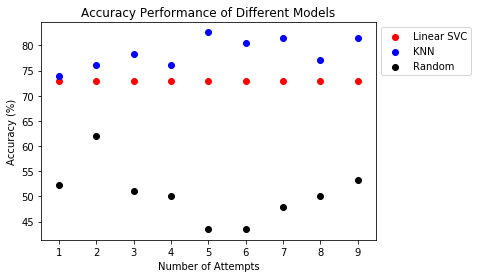

The rank of best model for average accuracy is: 
1st: 78.6231884057971 for KNN Model
2nd: 72.82608695652173 for Linear SVC Model
3rd: 50.36231884057971 for Random Model


In [32]:
### Plotting accuracy of each model
plt.figure()
num_tries = range(1,10) ### Scatter plot of acccuracy marks for each model
plt.scatter(num_tries,score_svc_list, color="red")
plt.scatter(num_tries,score_knn_list, color="blue")
plt.scatter(num_tries,score_rand_list, color="black")
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of Attempts")
plt.title("Accuracy Performance of Different Models")
plt.gca().legend(('Linear SVC','KNN', "Random"),bbox_to_anchor=(1, 1))
plt.show()

### Determining average accuracy of each model
avg_accuracy_svc = np.mean(score_svc_list)  ### Mean accuracy for SVC
avg_accuracy_knn = np.mean(score_knn_list)  ### Mean accuracy for KNN
avg_accuracy_rand = np.mean(score_rand_list)  ### Mean accuracy for Random
avg_accuracy_tup = [(avg_accuracy_svc,"Linear SVC Model"), (avg_accuracy_knn,"KNN Model"), 
                    (avg_accuracy_rand,"Random Model")]
sorted_avg_list = sorted(avg_accuracy_tup, reverse=True)
print ("The rank of best model for average accuracy is: ") 
print ("1st:",sorted_avg_list[0][0], "for", sorted_avg_list[0][1])
print ("2nd:", sorted_avg_list[1][0], "for", sorted_avg_list[1][1])
print ("3rd:", sorted_avg_list[2][0], "for", sorted_avg_list[2][1])

# Grapes Database
The database of grapes was included for some extra information and to join databases by the grape variety. But that is an additional feature and not a quantitative result for this project. 

In [33]:
# Obtaining list of red, white and rose grapes 
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_grape_varieties#Red_grapes").text
soup = BeautifulSoup(website_url,'lxml')
tables = soup.findAll('table', {"class":["sortable"]})

# Separating tables by category
red_tables = tables[0]
white_tables = tables[1]
rose_tables = tables[2]

# Extracting data from tables and pushing to a database
red_grapes = []
classification = []
for row in red_tables.findAll('tr'):
    red_cells = row.findAll(['th','td'])
    red_grapes.append(red_cells[0].text[:-2])
    classification.append("Red")
    
# Extracting data from tables and pushing to a database
white_grapes = []
for row in white_tables.findAll('tr'):
    white_cells = row.findAll(['th','td'])
    white_grapes.append(white_cells[0].text[:-2])
    classification.append("White")
    
# Extracting data from tables and pushing to a database
rose_grapes = []
for row in rose_tables.findAll('tr'):
    rose_cells = row.findAll(['th','td'])
    rose_grapes.append(rose_cells[0].text[:-2])
    classification.append("Rose")

grapes_list = red_grapes+white_grapes+rose_grapes

In [34]:
# Dataframe for grape variety and their specific categories
df2 = pd.DataFrame({"Grape_Classification":classification, "Grapes":grapes_list})
df2

,Grape_Classification,Grapes
0,Red,Common Name(s
1,Red,Abbuot
2,Red,Abourio
3,Red,Alexandrooul
4,Red,Akhashen
5,Red,Abrusc
6,Red,Acolo
7,Red,Ada Karas
8,Red,Affenthale
9,Red,Agiorgitik


# User Integrated Database for Wine Suggestion

In [35]:
### Creating a database of random users 
user_id = [] 
favorite_grape = []
wine_preference = []
most_common_grape = []
for i in range (10):   ### Getting 10 users for prototype purposes 
    random_id = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(10)])
    while random_id in user_id:     ### Avoiding the possibility of having different users with the same ID
        new_random_id = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(10)])
        user_id.append(new_random_id)
    user_id.append(random_id)

    random_int_grapes = randint(0,len(df2))   ### Assigning favorite grapes to each user randomly from the grape dataframe
    favorite_grape.append(df2.loc[random_int_grapes, "Grapes"])
    
    user_wine_list = []      ### Creating a list of wines for each user and obtaining most common category of wine
    for i in range(100):       
        random_int_wine = randint(0,len(df_clean_filled)-5)
        user_wine_list.append(df_clean_filled.loc[random_int_wine, "Wine_ID"])
    wine_str = json.dumps(user_wine_list)
    wine_preference.append(wine_str)
    most_common_grape.append(collections.Counter(user_wine_list).most_common(1)[0][0])

### Dataframe for users 
df3 = pd.DataFrame({"User_ID":user_id, "Favorite_Grape":favorite_grape,"Wine_Selection":wine_preference,
                    "Preferred_Wine":most_common_grape}) 
df3

,User_ID,Favorite_Grape,Wine_Selection,Preferred_Wine
0,OTptwEcsS5,Agni (grape) [cs,"[""FoFUqTwpUgQQq8a"", ""MdQ457L8gm5p6AB"", ""1TlTEu...",8ZJgYIZ5V04zycb
1,mdG5RZrbSz,Vespaiol,"[""QaKdLq0etLsRsx4"", ""0ss7GrSAvdPiln6"", ""5iSmIK...",yaG61eik9G2SuSs
2,ALRnS8IGve,Lagorth,"[""oj2qozNIN0zyTb9"", ""SkWNJ0LGRPSsSok"", ""7Ckb7v...",oj2qozNIN0zyTb9
3,KZEtCjZ3Cs,Pinot blanc / Pinot bianco / Klevner / Weissbu...,"[""18MkLVonphFwUnd"", ""F4KAJOzNkzqYjkB"", ""HyUiCI...",F4KAJOzNkzqYjkB
4,i9HMkMKB4h,Babi,"[""UqPrZ8gCo2HCPB2"", ""vnTXw1QN7S0J30S"", ""sqRruA...",UqPrZ8gCo2HCPB2
5,7Mq8GUDAh8,Aspiran Noi,"[""wheXDJhER7Hv2al"", ""HKiIsNK3XCiHOwk"", ""g2FvB5...",wheXDJhER7Hv2al
6,Ch5GhYRg0a,Falanghin,"[""hG0DERG90MytwuF"", ""da0qKvI4N5fmF8Y"", ""H7tA9n...",8uEPbjkpwCqeY7k
7,A0oGBbYslJ,Negru de Dragasan,"[""pPKcGctqOWVj6uS"", ""1wqcymReCP09j6v"", ""ISPZ8z...",ISPZ8zne8K46x8Q
8,RslfRs4LLq,Rossignol,"[""PRkorhFHMfKVo9M"", ""09GNxWPY6Cow2Li"", ""W521bl...",09GNxWPY6Cow2Li
9,zWRHgaW6xx,Helfensteine,"[""8ZJgYIZ5V04zycb"", ""sR3E1GLGH1IXQDJ"", ""PRkorh...",vzdrxPwRjxlZc2l


In [36]:
### Creating local database memory
engine = create_engine('sqlite://', echo=False)

### Exporting dataframes to database
df_clean_filled.to_sql("wine_tech",con=engine)
df2.to_sql("grapes_db", con=engine, index=False)
df3.to_sql("users", con=engine, index = False)

### Joining relational databases by Wine Selection and Classification string
query = '''
SELECT users.user_id, users.favorite_grape, grapes_db.grape_classification, 
users.wine_selection, users.preferred_wine, wine_tech.pH, wine_tech.ta, wine_tech.alcohol
FROM users
 JOIN grapes_db ON grapes_db.grapes = users.favorite_grape
 JOIN wine_tech ON wine_tech.wine_id = users.preferred_wine
'''

### First Join statement relates user database and grape database by favorite grape
### Second Join statement relates user database and technical database by preferred wine 

df4 = pd.read_sql_query(query,engine)
df4

,User_ID,Favorite_Grape,Grape_Classification,Wine_Selection,Preferred_Wine,pH,TA,Alcohol
0,OTptwEcsS5,Agni (grape) [cs,Red,"[""FoFUqTwpUgQQq8a"", ""MdQ457L8gm5p6AB"", ""1TlTEu...",8ZJgYIZ5V04zycb,3.65,0.70,14.1
1,mdG5RZrbSz,Vespaiol,White,"[""QaKdLq0etLsRsx4"", ""0ss7GrSAvdPiln6"", ""5iSmIK...",yaG61eik9G2SuSs,3.58,0.62,13.6
2,ALRnS8IGve,Lagorth,White,"[""oj2qozNIN0zyTb9"", ""SkWNJ0LGRPSsSok"", ""7Ckb7v...",oj2qozNIN0zyTb9,3.78,0.64,14.2
3,KZEtCjZ3Cs,Pinot blanc / Pinot bianco / Klevner / Weissbu...,White,"[""18MkLVonphFwUnd"", ""F4KAJOzNkzqYjkB"", ""HyUiCI...",F4KAJOzNkzqYjkB,3.66,0.63,13.8
4,i9HMkMKB4h,Babi,Red,"[""UqPrZ8gCo2HCPB2"", ""vnTXw1QN7S0J30S"", ""sqRruA...",UqPrZ8gCo2HCPB2,3.90,0.52,13.9
5,7Mq8GUDAh8,Aspiran Noi,Red,"[""wheXDJhER7Hv2al"", ""HKiIsNK3XCiHOwk"", ""g2FvB5...",wheXDJhER7Hv2al,3.63,0.57,14.3
6,Ch5GhYRg0a,Falanghin,White,"[""hG0DERG90MytwuF"", ""da0qKvI4N5fmF8Y"", ""H7tA9n...",8uEPbjkpwCqeY7k,3.31,0.65,15.1
7,A0oGBbYslJ,Negru de Dragasan,Red,"[""pPKcGctqOWVj6uS"", ""1wqcymReCP09j6v"", ""ISPZ8z...",ISPZ8zne8K46x8Q,3.95,0.52,14.4
8,RslfRs4LLq,Rossignol,Red,"[""PRkorhFHMfKVo9M"", ""09GNxWPY6Cow2Li"", ""W521bl...",09GNxWPY6Cow2Li,3.38,0.62,14.0
9,zWRHgaW6xx,Helfensteine,Red,"[""8ZJgYIZ5V04zycb"", ""sR3E1GLGH1IXQDJ"", ""PRkorh...",vzdrxPwRjxlZc2l,3.80,0.52,14.3


As it can be seen above, different databases can be correlated in order to create a fully integrated database of users and user wine profiles. The next step would be to correlate different users and suggest similar wines based on the technical data acquired. This is one application of this project to a real life scenario.

# End of Code